In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import NeuralNet as nn

from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples=500, noise=0.2)
y_train = y_train[:, None]

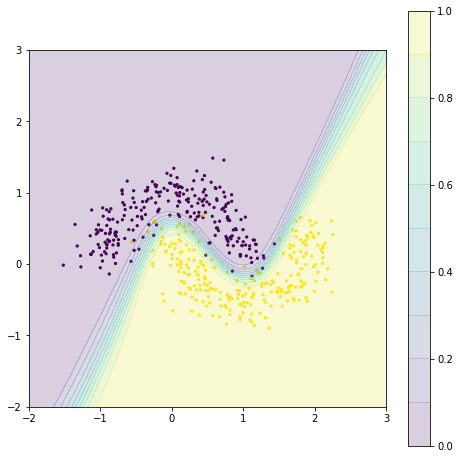

In [2]:
class BayesianNetwork(nn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__(
            w1_m=np.zeros((n_input, n_hidden)),
            w1_s=np.zeros((n_input, n_hidden)),
            b1_m=np.zeros(n_hidden),
            b1_s=np.zeros(n_hidden),
            w2_m=np.zeros((n_hidden, n_hidden)),
            w2_s=np.zeros((n_hidden, n_hidden)),
            b2_m=np.zeros(n_hidden),
            b2_s=np.zeros(n_hidden),
            w3_m=np.zeros((n_hidden, n_output)),
            w3_s=np.zeros((n_hidden, n_output)),
            b3_m=np.zeros(n_output),
            b3_s=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.qw1 = nn.random.Gaussian(
            self.w1_m, nn.softplus(self.w1_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb1 = nn.random.Gaussian(
            self.b1_m, nn.softplus(self.b1_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qw2 = nn.random.Gaussian(
            self.w2_m, nn.softplus(self.w2_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb2 = nn.random.Gaussian(
            self.b2_m, nn.softplus(self.b2_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qw3 = nn.random.Gaussian(
            self.w3_m, nn.softplus(self.w3_s),
            p=nn.random.Gaussian(0, 1)
        )
        self.qb3 = nn.random.Gaussian(
            self.b3_m, nn.softplus(self.b3_s),
            p=nn.random.Gaussian(0, 1)
        )
        h = nn.tanh(x @ self.qw1.draw() + self.qb1.draw())
        h = nn.tanh(h @ self.qw2.draw() + self.qb2.draw())
        self.py = nn.random.Bernoulli(logit=h @ self.qw3.draw() + self.qb3.draw(), data=y)
        return self.py.mu.value
    
model = BayesianNetwork(2, 5, 1)
optimizer = nn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)

for i in range(2000):
    model.clear()
    model(x_train, y_train)
    elbo = model.elbo()
    elbo.backward()
    optimizer.update()
    
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y = np.mean([model(x_grid).reshape(100, 100) for _ in range(10)], axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train[:,0], s=5)
plt.contourf(x1, x2, y, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()